# **Time Series Forecasting with TensorFlow: A Comprehensive Guide**

In this skill, we'll cover time series forecasting and apply what we learned about temporal patterns in the last skill. I designed skill for you to code along to understand each step conceptually and programmatically.

## **1. What is a sine wave? What is a series? Why use this sine example vs. others?**

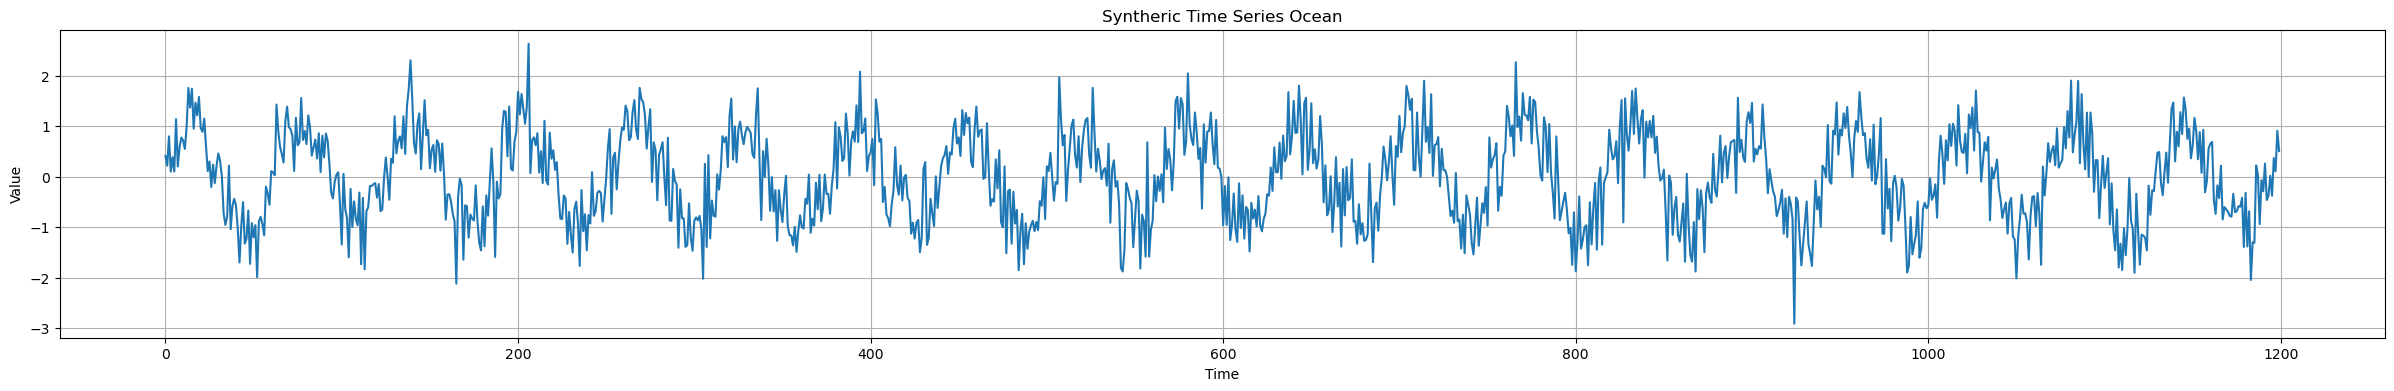

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic time series data
time = np.arange(1200)# 1200 time steps
series = np.sin(0.1 * time) + np.random.normal(scale=0.5, size=1200) # Sine wave with noise

# Plot the synthetic data
plt.figure(figsize=(30,4))
plt.plot(time, series)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Syntheric Time Series Ocean')
plt.grid(True)
plt.show()

In [2]:
series

array([0.41316466, 0.22045037, 0.80318986, ..., 0.1098628 , 0.91276863,
       0.51235898])

## **2. What is `split_time`? Explaining the slicing and visualization.**


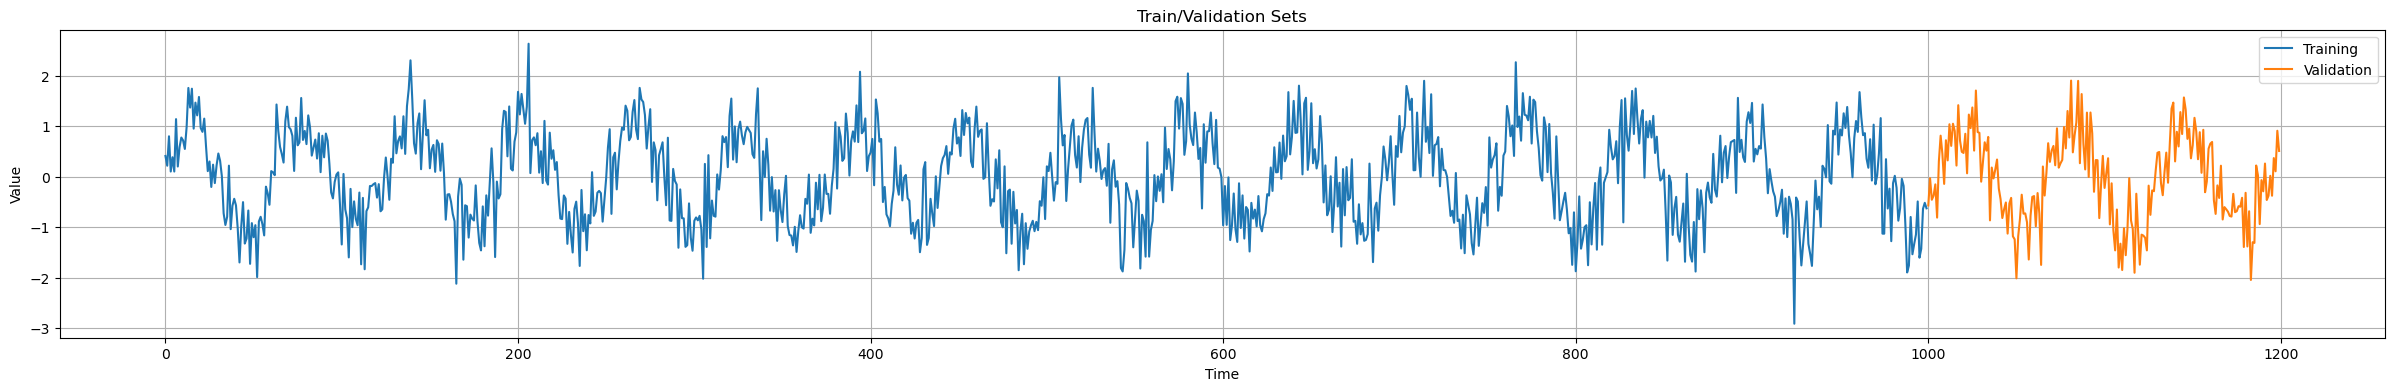

In [3]:
# Split the data
split_time = 1000
x_train = series[:split_time]
x_valid = series[split_time:]

# Plot the split
plt.figure(figsize=(30, 4))
plt.plot(time[:split_time], x_train, label='Training')
plt.plot(time[split_time:], x_valid, label='Validation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Train/Validation Sets')
plt.legend()
plt.grid(True)
plt.show()

# **3. What is `windowed_dataset`, and why do we use it?**


In [4]:
import tensorflow as tf

# Define a windowed dataset function
def windowed_dataset(series, window_size, batch_size):
    '''
    Create a windowed dataset for training our model.

    Parameters:
    - series: The full time series data (wave heights).
    - window_size: The number of data points in each window (how much of the wave).
    - batch_size: The number of windows processed in one batch.

    Returns:
    - A TensorFlow dataset with overlapping windows and their corresponding labels.
    '''

    # 1. Convert the time series into individual elements
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # 2. Create windows of size (window_size + 1)
    # Each window includes `window_size` inputs (features) and 1 label (the next value)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # 3. Flatten each window
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # 4. Split each window into features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # 5. Shuffle the windows
    dataset = dataset.shuffle(buffer_size=100)

    # 6. Batch multiple windows together
    dataset = dataset.batch(batch_size)

    # 7. Prefetch to optimize during training
    dataset = dataset.prefetch(1)

    # Return the prepared dataset
    return dataset


# Define parameters
window_size = 20
batch_size = 32
num_epochs = 20

# Create windowed datasets
train_dataset = windowed_dataset(x_train, window_size, batch_size).repeat()
valid_dataset = windowed_dataset(x_valid, window_size, batch_size).repeat()

steps_per_epoch = len(x_train) // batch_size
validation_steps = len(x_valid) // batch_size

## **4. What is the model seeing and learning?**

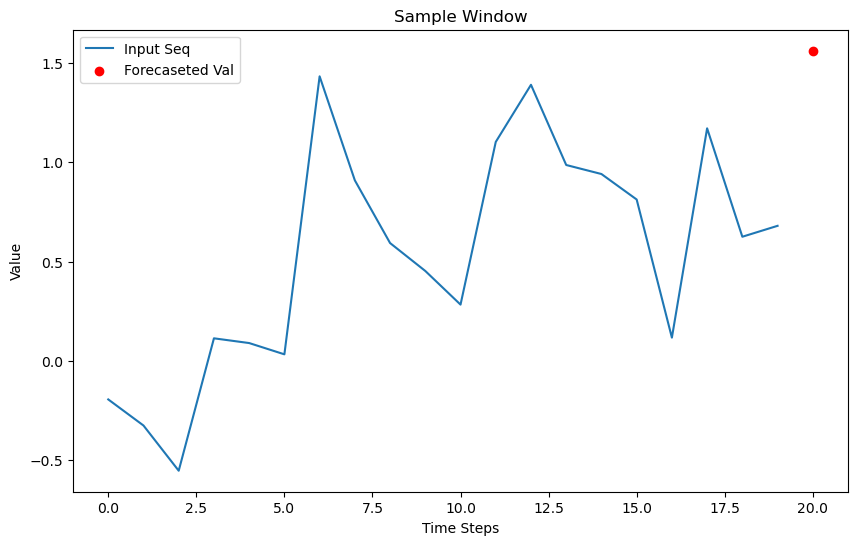

In [5]:
# Visualize a single sample window
for sample_input, sample_output in train_dataset.take(1):
    plt.figure(figsize=(10, 6))
    plt.plot(range(window_size), sample_input[0].numpy(), label='Input Seq')
    plt.scatter(window_size, sample_output[0].numpy(), label='Forecaseted Val', color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Sample Window')
    plt.legend()
    plt.show()
    break

## **5. Build and Compile the Model**

In [6]:
# Build the model (Baseline model)
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[window_size]),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mse'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221 (884.00 B)

 Trainable params: 221 (884.00 B)

 Non-trainable params: 0 (0.00 B)

## **6. Train the model**

In [7]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7973 - mse: 0.7973 - val_loss: 0.5156 - val_mse: 0.5156
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5373 - mse: 0.5373 - val_loss: 0.4448 - val_mse: 0.4448
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4661 - mse: 0.4661 - val_loss: 0.4145 - val_mse: 0.4145
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4207 - mse: 0.4207 - val_loss: 0.3931 - val_mse: 0.3931
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3950 - mse: 0.3950 - val_loss: 0.3764 - val_mse: 0.3764
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3782 - mse: 0.3782 - val_loss: 0.3622 - val_mse: 0.3622
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3714 - mse: 0.3714 - val_loss: 0.3505 - val_mse: 0.3505
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3517 - mse: 0.3517 - val_loss: 0.3419 - val_mse: 0.3419
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3408 - mse: 

## **7. Plot performance using loss—NOT accuracy.**


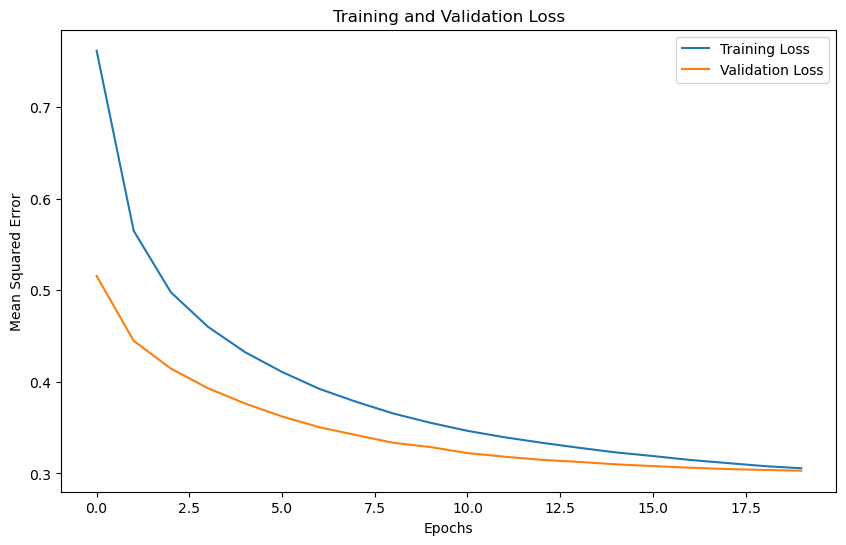

In [10]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## **8. Make Predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


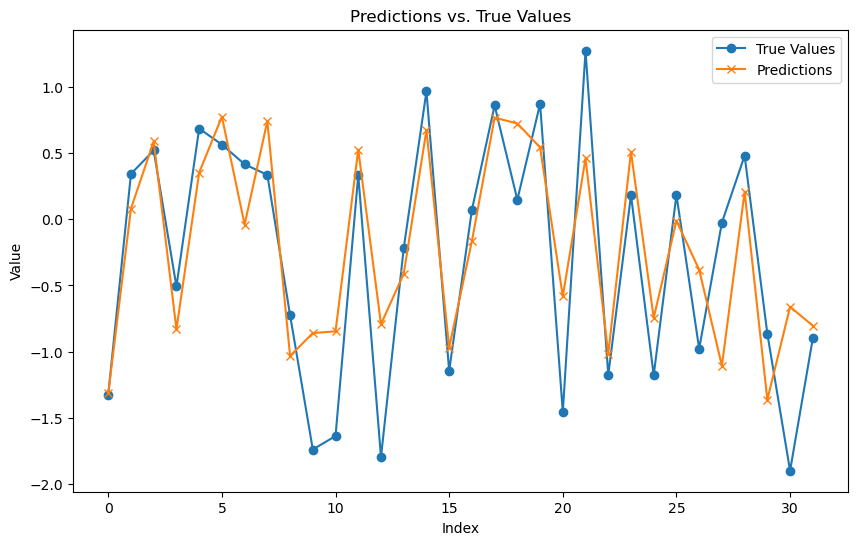

In [11]:
# Make predictions
predictions = []
true_values = []
for input_batch, target_batch in valid_dataset.take(1):
    predictions = model.predict(input_batch).flatten()
    true_values = target_batch.numpy()
    break

# Plot predictions vs. true values
plt.figure(figsize=(10, 6))
plt.plot(true_values, label='True Values', marker='o')
plt.plot(predictions, label='Predictions', marker='x')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predictions vs. True Values')
plt.legend()
plt.show()